In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

class MixtureDensityNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_gaussians):
        super(MixtureDensityNetwork, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_gaussians = n_gaussians

        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.pi_layer = nn.Linear(hidden_dim, n_gaussians)
        self.mu_layer = nn.Linear(hidden_dim, n_gaussians * output_dim)
        self.sigma_layer = nn.Linear(hidden_dim, n_gaussians * output_dim)

    def forward(self, x):
        h = F.softplus(self.hidden_layer(x))
        pi = F.softmax(self.pi_layer(h), dim=1)
        mu = self.mu_layer(h).view(-1, self.n_gaussians, self.output_dim)
        sigma = F.softplus(self.sigma_layer(h)).view(-1, self.n_gaussians, self.output_dim)

        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, target):
    normal = torch.distributions.Normal(mu, sigma)
    log_prob = normal.log_prob(target.unsqueeze(1).expand_as(mu))
    weighted_logprob = log_prob + torch.log(pi.unsqueeze(-1))
    return -torch.logsumexp(weighted_logprob, dim=1).mean()

In [2]:
# Generate dataset
n_samples = 1000
X_full, _ = make_moons(n_samples=n_samples, noise=0.1)
X = X_full[:, 0].reshape(-1, 1)  # Use only the first column as input
Y = X_full[:, 1].reshape(-1, 1)  # Predict the second column

# Add some noise to Y to make the problem more suitable for MDN
Y += 0.1 * np.random.randn(n_samples, 1)

# Convert to PyTorch tensors
X = torch.FloatTensor(X)
Y = torch.FloatTensor(Y)

# Model parameters
input_dim = 1
hidden_dim = 20
output_dim = 1
n_gaussians = 5

# Create and train the model
mdn = MixtureDensityNetwork(input_dim, hidden_dim, output_dim, n_gaussians)
optimizer = torch.optim.Adam(mdn.parameters(), lr=0.01)

n_epochs = 500
batch_size = 64

for epoch in range(n_epochs):
    for i in range(0, n_samples, batch_size):
        try:
            x_batch = X[i:i+batch_size]
            y_batch = Y[i:i+batch_size]
    
            pi, mu, sigma = mdn(x_batch)
            loss = mdn_loss(pi, mu, sigma, y_batch)
        except ValueError:
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.5270
Epoch 10, Loss: 0.4342
Epoch 20, Loss: 0.4021
Epoch 30, Loss: 0.2897
Epoch 40, Loss: 0.2520
Epoch 50, Loss: 0.2198
Epoch 60, Loss: 0.1702
Epoch 70, Loss: 0.1881
Epoch 80, Loss: 0.1788
Epoch 90, Loss: 0.1717
Epoch 100, Loss: 0.1667
Epoch 110, Loss: 0.1632
Epoch 120, Loss: 0.1606
Epoch 130, Loss: 0.1584
Epoch 140, Loss: 0.1562
Epoch 150, Loss: 0.1540
Epoch 160, Loss: 0.1517
Epoch 170, Loss: 0.1494
Epoch 180, Loss: 0.1473
Epoch 190, Loss: 0.1453
Epoch 200, Loss: 0.1433
Epoch 210, Loss: 0.1415
Epoch 220, Loss: 0.1398
Epoch 230, Loss: 0.1385
Epoch 240, Loss: 0.1376
Epoch 250, Loss: 0.1370
Epoch 260, Loss: 0.1364
Epoch 270, Loss: 0.1358
Epoch 280, Loss: 0.1352
Epoch 290, Loss: 0.1344
Epoch 300, Loss: 0.1334
Epoch 310, Loss: 0.1322
Epoch 320, Loss: 0.1314
Epoch 330, Loss: 0.1332
Epoch 340, Loss: 0.1256
Epoch 350, Loss: 0.1318
Epoch 360, Loss: 0.1232
Epoch 370, Loss: 0.1242
Epoch 380, Loss: 0.1182
Epoch 390, Loss: 0.1152
Epoch 400, Loss: 0.1228
Epoch 410, Loss: 0.1204
Epo

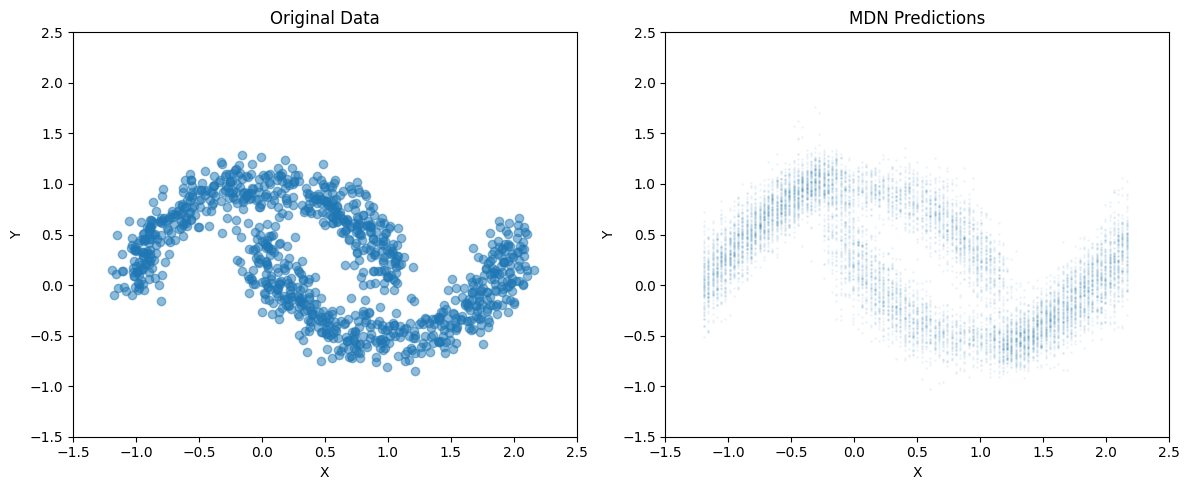

In [8]:
# Visualization
plt.figure(figsize=(12, 5))

# Original data
plt.subplot(121)
plt.scatter(X.numpy(), Y.numpy(), alpha=0.5)
plt.ylim(-1.5, 2.5)
plt.xlim(-1.5, 2.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')

# MDN predictions
plt.subplot(122)
with torch.no_grad():
    pi, mu, sigma = mdn(X)

# Create a fine-grained grid for smooth visualization
x_grid = torch.linspace(X.min(), X.max(), 100).unsqueeze(1)
pi_grid, mu_grid, sigma_grid = mdn(x_grid)

# Sample from the mixture distribution
n_samples_per_x = 100
samples = torch.zeros(len(x_grid), n_samples_per_x)

for i in range(len(x_grid)):
    idx = torch.multinomial(pi_grid[i], n_samples_per_x, replacement=True)
    samples[i] = torch.normal(mu_grid[i, idx, 0], sigma_grid[i, idx, 0])

plt.scatter(x_grid.detach().numpy().repeat(n_samples_per_x), samples.detach().numpy().flatten(), alpha=0.05, s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(-1.5, 2.5)
plt.xlim(-1.5, 2.5)
plt.title('MDN Predictions')

plt.tight_layout()
plt.show()

In [53]:
from ipywidgets import interact

import numpy as np
import matplotlib.pylab as plt
from scipy.stats import norm

@interact(p=(-1.7, 2.7, 0.01))
def f(p):
    pi, mu, sigma = mdn(torch.FloatTensor(np.array([[p]])))
    pi, mu, sigma = (np.array(i.detach())[0] for i in (pi, mu, sigma))
    ys = np.linspace(-1.5, 1.5, 200)
    pdf = np.zeros(ys.shape)

    for i in range(len(pi)):
        pdf += norm(mu[i], sigma[i]).pdf(ys) * pi[i]

    # Original data
    plt.subplot(121)
    plt.scatter(X.numpy(), Y.numpy(), alpha=0.5)
    plt.ylim(-1.5, 1.5)
    plt.xlim(-1.5, 2.5)
    plt.vlines(x=p, ymin=-1.5, ymax=1.5, color='orange')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Original Data')

    # Distribution going out
    plt.subplot(122)

    plt.plot(ys, pdf, label='Distribution going out.')
    plt.legend()
    plt.title('Estimated distribution')
    


interactive(children=(FloatSlider(value=0.5000000000000002, description='p', max=2.7, min=-1.7, step=0.01), Ou…

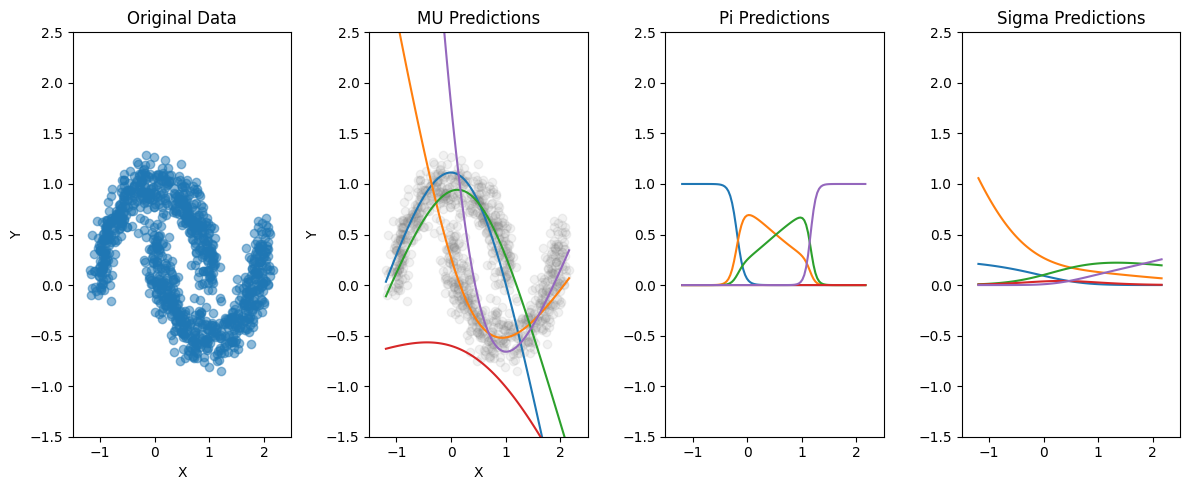

In [74]:
# Visualization
plt.figure(figsize=(12, 5))

# Original data
plt.subplot(141)
plt.scatter(X.numpy(), Y.numpy(), alpha=0.5)
plt.ylim(-1.5, 2.5)
plt.xlim(-1.5, 2.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')

# MDN predictions
plt.subplot(142)
with torch.no_grad():
    pi, mu, sigma = mdn(X)

# Create a fine-grained grid for smooth visualization
x_grid = torch.linspace(X.min(), X.max(), 100).unsqueeze(1)
pi_grid, mu_grid, sigma_grid = mdn(x_grid)

plt.scatter(X.numpy(), Y.numpy(), alpha=0.1, color='gray')
for i in range(pi.shape[1]):
    plt.plot(x_grid, mu_grid.detach()[:, i])
    
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(-1.5, 2.5)
plt.xlim(-1.5, 2.5)
plt.title('MU Predictions')

# MDN predictions
plt.subplot(143)

for i in range(pi.shape[1]):
    plt.plot(x_grid, pi_grid.detach()[:, i])
    
plt.ylim(-1.5, 2.5)
plt.xlim(-1.5, 2.5)
plt.title('Pi Predictions')

# MDN predictions
plt.subplot(144)

for i in range(pi.shape[1]):
    plt.plot(x_grid, sigma_grid.detach()[:, i])
    
plt.ylim(-1.5, 2.5)
plt.xlim(-1.5, 2.5)
plt.title('Sigma Predictions')

plt.tight_layout()
plt.show()